In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as d

from datetime import date,datetime, timedelta


#bigger fonts
import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rcParams.update({'font.size': 20})

In [262]:

clock = datetime(2020,6,24)+timedelta(seconds=3601)
clock

datetime.datetime(2020, 6, 24, 1, 0, 1)

In [263]:
clock.second

1

# Functions

In [138]:
def format_date(DATE='03-03-14',fmt='american'):
    # !!! American format
    if fmt=='american':
        month = int(DATE[0:2])
        day = int(DATE[3:5])
    else:
        day = int(DATE[0:2])
        month = int(DATE[3:5])

    year = int('20'+DATE[6:8])
    return year, month, day

def format_time(TIME='14:55:57'):
    hours = int(TIME[0:2])
    minutes = int(TIME[3:5])
    seconds = int(TIME[6:8])
    return hours, minutes, seconds


def DELTA_TIMES_SEC(DATE1,TIME1,DATE2,TIME2,verbose=False,fmt='american'):
    '''compute time intervals for a pair of date and time'''    
    year_1,month_1,day_1       = format_date(DATE1,fmt=fmt)
    hour_1,minutes_1,seconds_1 = format_time(TIME1)

    year_2,month_2,day_2       = format_date(DATE2,fmt=fmt)
    hour_2,minutes_2,seconds_2 = format_time(TIME2)

    #compute day difference
    from datetime import date
    start = date(year_1, month_1, day_1)
    end   = date(year_2, month_2, day_2)
    delta_days = (end-start).days
    if verbose:
        print('delta_days = ',delta_days)

    time_1_sec = hour_1*60*60 + minutes_1*60 + seconds_1
    time_2_sec = hour_2*60*60 + minutes_2*60 + seconds_2
    delta_time_sec = (time_2_sec-time_1_sec)
    if verbose:
        print('delta_sec = ', delta_time_sec)

    delta_tot_sec = delta_days*24*60*60 + (time_2_sec-time_1_sec)
    return delta_tot_sec

def convert_dates_times_into_deltasec(dates,times,fmt='american'):
    '''convert an array of dates and an array of times 
    into an array of interval times in seconds'''
    delta_sec =np.zeros(len(dates))
    for i in range(0,len(times)):
        delta_sec[i] = DELTA_TIMES_SEC(dates[0],times[0],dates[i],times[i],fmt=fmt)
        #print(delta_sec)
    return delta_sec


# Function to search for a key in the name of the files in a folder
def find_files_in_folder(key ,folder='/home/giorgio/Desktop/NHS/TOST_data/',verbose=False):
    '''give the key you want to find in file names contained in folder. 
    If you want to list all the files set key="*"  '''
    import subprocess
    ls = subprocess.Popen(['ls','', folder],
           stdout=subprocess.PIPE, 
           stderr=subprocess.STDOUT)
    ls_out,ls_err = ls.communicate()
    ls_out = str(ls_out)
    ls_out = ls_out.split('\\n')
    found=False
    key_lines = []
    if key=='*':
        if ':' in ls_out[1]:
            key_lines = ls_out[2:-1] #neglect parent folder
        else:
            key_lines = ls_out[1:-1] #neglect the first apostrophy

    else:
        for line in ls_out:
            if key in line and ':' not in line: #the ':' appears in the parent folder
                key_lines.append(line)
                found=True
        if (found and verbose):
            for kl in key_lines:
                print(kl)
        elif verbose:
                print('No file names with the key: ',key)
    return key_lines

# Find baby folder
def get_folder_for_baby(baby_id,verbose=False,whole_path=True):
    '''returns the path of the folder where the data of baby_id are stored'''
    baby_id = baby_id.upper()
    home_NHS ='/home/giorgio/Desktop/NHS/TOST_data/'
    if 'FMC' in baby_id:
        folder = home_NHS + 'TOST FMC Data Groomed/'
    elif 'PLC' in baby_id:
        folder = home_NHS + 'TOST PLC Data Groomed/'
    elif 'RGH' in baby_id:
        folder = home_NHS + 'TOST RGH Data Groomed/'
    #sometimes the id is e.g. RGH033 and sometimes RGH33
    try:
        _ = int(baby_id[-3:])
        # don't do str(int()) otherwise you lose the zeros
        keyword = str(baby_id[-3:])
    except:
        # This should handle when you give the id forgetting the initial zero 
        if str(baby_id[-3]) not in ['0','1','2','3','4','5','6','7','8','9']:
            keyword = '0'+str(baby_id[-2:])
    keyword = str(keyword) 
    if verbose:
        print('keyword = ',keyword)

    
    # even if verbose is true you don't want to print the last folder or the files here    
    ls = find_files_in_folder(key=keyword,folder=folder,verbose=False)
    
    
    if verbose:
        if len(ls)>1:
            print('WARNING: there are more occurrence for that baby id')
            print(ls)
            print('the first occurrence will be used: ',ls[0])
        elif len(ls)==0:
            print('It seems there are no data for ',baby_id)
            
    if len(ls)==0:        
        ls=None
            
    
    if whole_path and ls!=None:
        #print('folder= ',folder)
        #print('len(ls)= ',len(ls))
        #print('ls=',ls)
        folder = folder + ls[0] + '/'
    elif ls!=None:
        folder = ls[0]
    
    if ls==None:
        return None
    else:
        return folder

def list_files_for_baby(baby_id,whole_path=True,verbose=False):
    '''Returns the name of the files with baby_id datas'''
    f = get_folder_for_baby(baby_id,verbose=verbose)
    ls = find_files_in_folder(key='*',folder=f)
    if whole_path:
        for i in range(len(ls)):
            ls[i] = f + ls[i]
    return ls


In [139]:
ls=None
ls==None

True

# CLASS BABY

In [140]:
# I don't want to read every time this file when instantiating new objects
# so I read it first
master_filename = "../TOST_data/TOST_State_Durham.xlsx"
master = pd.read_excel(master_filename,skip_blank_lines=True)
master = master[:-1] # delete last row which is a fake FMC001 with no data


In [141]:
def is_SameBaby(name1='FMC001',name2='FMC101',verbose=False):
    '''check if the two id for the baby are equivalent 
    even if they are in different formats, 
    e.g. with initial zero or lower/upper characters.'''

    hospital = bool(str(name1[0:3]).lower() in str(name2))or(str(name1[0:3]).upper() in str(name2))
    last_three = bool(str(name1)[-3:]==str(name2)[-3:])
    last_two = bool(str(name1)[-2:]==str(name2)[-2:])
    third_last_is_zero_in_name2 = bool(str(name2)[-3]=='0')
    third_last_is_zero_in_name1 = bool(str(name1)[-3]=='0')
    third_last_is_character_in_name1 = bool(str(name1)[-3] not in ['0','1','2','3','4','5','6','7','8','9'])
    third_last_is_character_in_name2 = bool(str(name2)[-3] not in ['0','1','2','3','4','5','6','7','8','9'])

    numbers_right = bool(last_three or \
                         ((last_two and third_last_is_zero_in_name2 and third_last_is_character_in_name1) or \
                        (last_two and third_last_is_character_in_name2 and  third_last_is_zero_in_name1) ))

    total = bool(hospital and numbers_right)

    if verbose:
        print('#################################################################')
        print("Is the name of the hospital found in the original name? ",hospital)
        print("Are the last three character the same? \t\t\t",last_three)
        print("Are the last two character the same? \t\t\t",last_two)
        print("Are the id numbers equivalent? \t\t\t\t",numbers_right)
        print('---------------------------------------------------------------')
        print("Are the file names ",name1,' and ',name2," equivalent? \t",total)
        print('#################################################################')
    
    return total

In [142]:
is_SameBaby('FMC010','FMC10',verbose=False)

True

In [217]:
def find_baby_name_and_index_in_master(baby_id,master=master):
    '''it scans all of the name of the babies in the master file and return the correct name and its index'''
    baby_names = np.array(master['Study Number (Original)'])
    found=False
    for i in range(len(baby_names)):        
        if is_SameBaby(baby_id,baby_names[i]):
            name_original = baby_names[i]
            index_original = i
            if found: #(already)
                print('WARNING: more than one baby for the same id!!!')
                print('baby_id = ',baby_id, 'with original name = ',baby_names[i],' at index = ',i)
            else:
                found=True
    return name_original, index_original
    
    
    
class baby:
    def __init__(self,baby_id,babies=master,verbose=False):
        '''Provide the study number to initialise a baby, e.g. baby_id="FMC003" '''
        self.verbose=verbose
        self.baby_id=baby_id.upper()
        self.data_found=True
        try:
            index = list(babies['Study Number (Original)']).index(baby_id)
            original_name = baby_id
        except:
            original_name , index = find_baby_name_and_index_in_master(baby_id.upper())
        if self.verbose:
            print('The original name of the baby case is: ',original_name)
        self.original_name = original_name
        self.gender = babies['Gender'][index]
        self.weight_grams = babies['Birth Weight in Grams'][index]
        self.date_time = str(babies['Date & Time of Birth'][index]).split()
        
        self.date_birth = str(babies['Date & Time of Birth'][index]).split(' ')[0]
        self.time_birth = str(babies['Date & Time of Birth'][index]).split(' ')[1]
        self.year_birth  = int(self.date_birth.split('-')[0])
        self.month_birth = int(self.date_birth.split('-')[1])
        self.day_birth = int(self.date_birth.split('-')[2])
        self.hours_birth = self.time_birth.split(':')[0]
        self.minutes_birth = self.time_birth.split(':')[1]
        self.seconds_birth = self.time_birth.split(':')[2]
        
        try:
            self.files = list_files_for_baby(self.baby_id,verbose=verbose)
            if verbose:
                print('I am loading the files for baby = ',self.baby_id)
        except :
            print('NO MEASUREMENTS FOR BABY',self.baby_id)
            self.data_found=False
            #raise ValueError('FILE NOT FOUND FOR BABY: ',self.baby_id)
        
        
        # array of tables with the measurements in different day or modality (wrist/foot)
        self.measurements = []
        
        if self.data_found:
            for i in range(len(self.files)):
                if self.verbose:
                    print('Loading file: ',self.files[i])
                
                data = pd.read_csv(self.files[i])
                # if you use the following you need to be sure that you have (all of those column name)
                #and sometimes there is no PI so it's not ideal
                #data = pd.read_csv(self.files[i],skipinitialspace=True,usecols=['Date','Time','SpO2','PR','PI'])

                self.measurements.append(data) 

                #if self.verbose:
                #    print(pd.read_csv(self.files[i]))

                
            if self.verbose:
                print('--------------------')
            self.measurements_date = []
            self.measurements_time = []
            self.measurements_SpO2_median = []
            self.measurements_PR_median = []
            self.measurements_PI_median = []


            for i in range(len(self.files)):
                
                if self.verbose:
                    print('Reading from file: ',self.files[i])
                    #print(self.measurements[i].columns.values)
                
                self.measurements_date.append(self.measurements[i]['Date'][0])
                self.measurements_time.append(self.measurements[i]['Time'][0])
                self.measurements_SpO2_median.append(self.measurements[i]['SpO2'].dropna().median())
                self.measurements_PR_median.append(self.measurements[i]['PR'].dropna().median())
                try:
                    PI_median = self.measurements[i]['PI'].dropna().median()
                    if PI_median!=8000:
                        self.measurements_PI_median.append(PI_median)
                except:
                    self.measurements_PI_median.append(np.nan)


# Tests on a single baby

In [218]:
FMC003 = baby('FMC003',verbose=True)

The original name of the baby case is:  FMC003
keyword =  003
I am loading the files for baby =  FMC003
Loading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_003/G_FMC003_Day1_Rt Foot.csv
Loading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_003/G_FMC003_Day1_Rt wrist.csv
Loading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_003/G_PHN_FMC003_Day3_Lt Foot.csv
Loading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_003/G_PHN_FMC003_Day3_Rt wrist.csv
--------------------
Reading from file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_003/G_FMC003_Day1_Rt Foot.csv
Reading from file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_003/G_FMC003_Day1_Rt wrist.csv
Reading from file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_003/G_PHN_FMC003_Day3_Lt Foot.csv
Reading from file:  /home/giorgio/Desktop/NHS/TOST_dat

In [202]:
FMC003.measurements_date

['14+AC0-04+AC0-03', '03-04-14', '14-05-03', '14-05-03']

In [ ]:
FMC001 = baby('FMC001',verbose=False)

In [176]:
FMC001.files


['/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_001/G_FMC001_Day1_Rt foot.csv',
 '/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_001/G_FMC001_Day1_Rt wrist.csv',
 '/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_001/G_PHN_FMC001_Day4_Rt wrist.csv',
 '/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_001/G_PHN_FMC001_Day5_Lt Foot.csv']

In [149]:
FMC001.measurements[1]['SpO2'].median()

97.0

In [150]:
#FMC001.__dict__

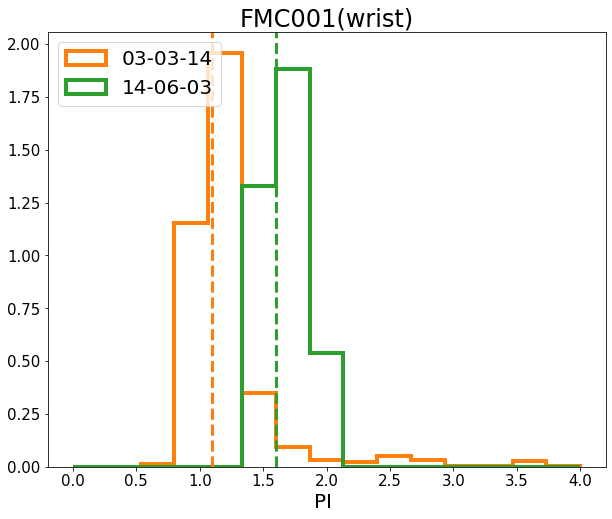

In [151]:
plt.figure(figsize=(10,8))
#plt.hist(FMC001.measurements[0]['SpO2'],bins=15,range=(87.5,100),lw=4,histtype='step',density=True,label=FMC001.measurements[0]['Date'][0])
#plt.axvline(FMC001.measurements[0]['SpO2'].median(),color='C0',lw=3,ls='dashed')
plt.hist(FMC001.measurements[1]['PI'],bins=15,color='C1',range=(0,4),lw=4,histtype='step',density=True,label=FMC001.measurements[1]['Date'][0])
plt.axvline(FMC001.measurements[1]['PI'].median(),color='C1',lw=3,ls='dashed')
plt.hist(FMC001.measurements[2]['PI'],bins=15,color='C2',lw=4,range=(0,4),histtype='step',density=True,label=FMC001.measurements[2]['Date'][0])
plt.axvline(FMC001.measurements[2]['PI'].median(),color='C2',lw=3,ls='dashed')
#plt.hist(FMC001.measurements[3]['SpO2'],bins=15,range=(87.5,100),lw=4,histtype='step',density=True,label=FMC001.measurements[3]['Date'][0])
#plt.axvline(FMC001.measurements[3]['SpO2'].median(),color='C3',lw=3,ls='dashed')
plt.xlabel('PI ')
plt.legend(loc=2)
plt.title(FMC001.baby_id+'(wrist)')
#plt.savefig('../plots/FMC001_histo_SpO2.png')
plt.show()


/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_001/G_FMC001_Day1_Rt foot.csv
/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_001/G_FMC001_Day1_Rt wrist.csv
/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_001/G_PHN_FMC001_Day4_Rt wrist.csv
/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_001/G_PHN_FMC001_Day5_Lt Foot.csv


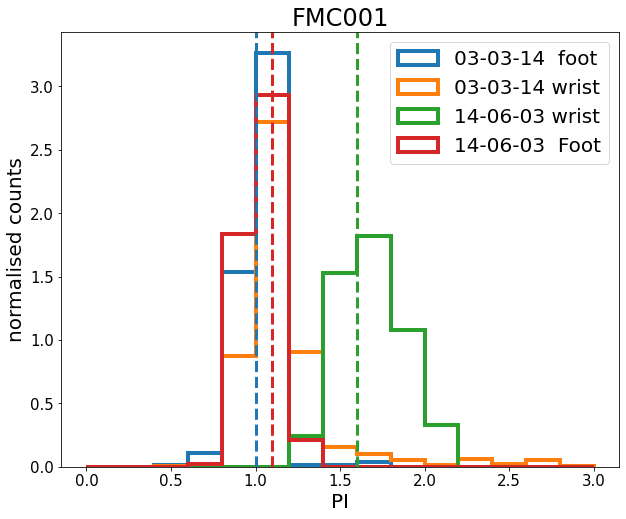

In [152]:
plt.figure(figsize=(10,8))

prop = 'PI'

width_SpO2=(87.5,100)

width_PI=(0,3.)
width=width_PI
#width=None


for i in range(len(FMC001.measurements)):
    print(FMC001.files[i])
    plt.hist(   FMC001.measurements[i][prop],bins=15,color='C'+str(i),range=width,lw=4,histtype='step',density=True,label=FMC001.measurements[i]['Date'][0]+' '+FMC001.files[i][-9:-4])
    plt.axvline(FMC001.measurements[i][prop].median(),color='C'+str(i),lw=3,ls='dashed')

    #+np.random.uniform(-0.3,+0.3)
    
plt.xlabel(prop)
plt.ylabel('normalised counts')
plt.legend(loc='best')
plt.title(FMC001.baby_id)
#plt.savefig('../plots/FMC001_histo_'+prop+'.png')
plt.show()


In [153]:
np.random.uniform(0,0.5)

0.2112927463961667

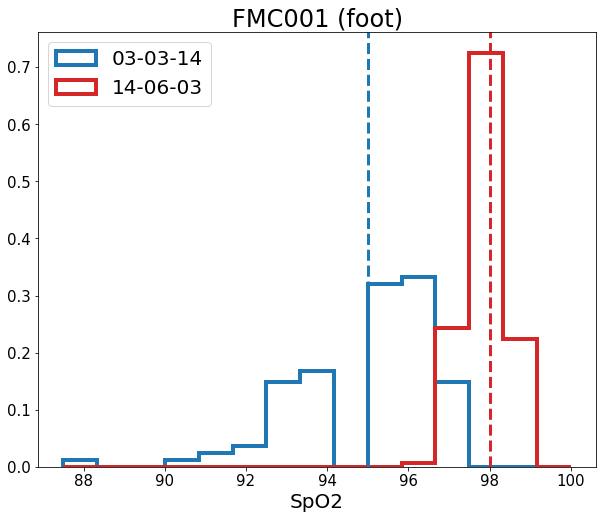

In [154]:
plt.figure(figsize=(10,8))
plt.hist(FMC001.measurements[0]['SpO2'],bins=15,range=(87.5,100),color='C0',lw=4,histtype='step',density=True,label=FMC001.measurements[0]['Date'][0])
plt.axvline(FMC001.measurements[0]['SpO2'].median(),color='C0',lw=3,ls='dashed')
plt.hist(FMC001.measurements[3]['SpO2'],bins=15,range=(87.5,100),color='C3',lw=4,histtype='step',density=True,label=FMC001.measurements[3]['Date'][0])
plt.axvline(FMC001.measurements[3]['SpO2'].median(),color='C3',lw=3,ls='dashed')
plt.xlabel('SpO2')
plt.legend(loc=2)
plt.title(FMC001.baby_id+' (foot)')
#plt.savefig('../plots/FMC001_histo_SpO2_foot.png')
plt.show()


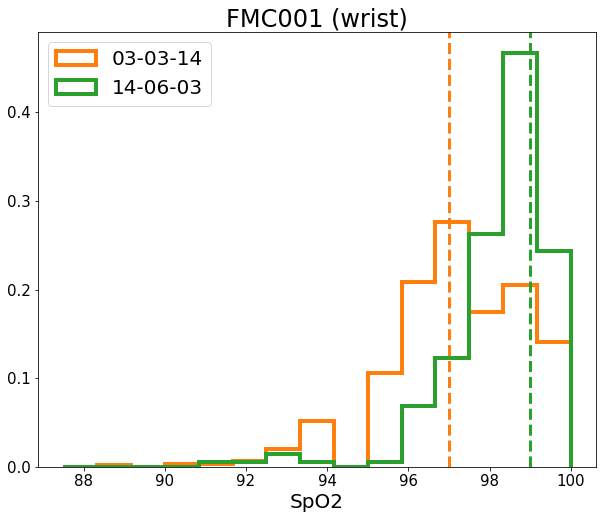

In [155]:
plt.figure(figsize=(10,8))
plt.hist(FMC001.measurements[1]['SpO2'],bins=15,range=(87.5,100),color='C1',lw=4,histtype='step',density=True,label=FMC001.measurements[1]['Date'][0])
plt.axvline(FMC001.measurements[1]['SpO2'].median(),color='C1',lw=3,ls='dashed')
plt.hist(FMC001.measurements[2]['SpO2'],bins=15,range=(87.5,100),color='C2',lw=4,histtype='step',density=True,label=FMC001.measurements[2]['Date'][0])
plt.axvline(FMC001.measurements[2]['SpO2'].median(),color='C2',lw=3,ls='dashed')
plt.xlabel('SpO2')
plt.legend(loc=2)
plt.title(FMC001.baby_id+' (wrist)')
#plt.savefig('../plots/FMC001_histo_SpO2_wrist.png')
plt.show()


In [156]:
list_files_for_baby('FMC007')

['/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_007/G_FMC007_Day1_Lt Foot.csv',
 '/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_007/G_FMC007_Day1_Rt Wrist.csv',
 '/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_007/G_PHN_FMC007_Day3_Rt Foot.csv',
 '/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_007/G_PHN_FMC007_Day3_Rt Wrist.csv']

In [157]:
FMC005 = baby('FMC005')

In [158]:
FMC007 = baby('FMC007',verbose=False)

In [159]:
FMC007.measurements[1]['Date'][0]

'03-05-14'

# Trying to read all of the babies from the master file (and counting the success/failure)

In [265]:
list_objects = []
index_good = []
index_bad = []
for i in range(len(master)):
    try:
        b = baby(master['Study Number (Original)'][i],verbose=False)
        list_objects.append(b)
        index_good.append(i)
        print(b.baby_id,"\t",b.date_birth,"\t",b.measurements_date)#,"\t",b.measurements_time)
    except:
        index_bad.append(i)

FMC003 	 2014-03-03 	 ['14+AC0-04+AC0-03', '03-04-14', '14-05-03', '14-05-03']
FMC004 	 2014-03-03 	 ['14-04-03']
FMC005 	 2014-03-03 	 ['03-05-14', '03-05-14', '14-07-03', '14-07-03']
FMC006 	 2014-03-04 	 ['03-04-14', '03-04-14', '14-06-03', '14-06-03']
FMC007 	 2014-03-05 	 ['14+AC0-05+AC0-03', '03-05-14', '14+AC0-07+AC0-03', '14+AC0-07+AC0-03']
FMC008 	 2014-03-05 	 ['14+AC0-05+AC0-03', '03-05-14', '14-09-03', '14-09-03']
RGH001 	 2014-03-05 	 ['14-09-03', '14-09-03', '14-06-03']
RGH002 	 2014-03-05 	 ['14-08-03', '14-08-03', '14-06-03', '14-06-03']
RGH003 	 2014-03-05 	 ['14-09-03', '14-09-03', '03-06-14', '03-06-14']
PLC001 	 2014-03-06 	 ['14-10-03', '03-07-14', '03-07-14']
PLC002 	 2014-03-06 	 ['14-08-03', '03-07-14', '03-07-14']
FMC009 	 2014-03-08 	 ['03-09-14', '03-09-14', '14+AC0-10+AC0-03', '14+AC0-10+AC0-03']
FMC010 	 2014-03-09 	 ['14-10-03', '14-10-03']
FMC011 	 2014-03-09 	 ['14-10-03']
FMC012 	 2014-03-10 	 ['14-10-03', '14-10-03', '03/13/14', '03/13/14']
FMC013 	 20

FMC093 	 2014-04-01 	 ['14-01-05', '14-01-05']
FMC094 	 2014-04-30 	 ['14-01-05', '14-01-05']
FMC095 	 2014-05-01 	 ['14-02-05']
FMC096 	 2014-05-01 	 ['14-02-05', '05-02-14', '14-04-05', '14-04-05']
PLC 028 	 2014-05-06 	 ['14-07-05', '14-07-05', '14-08-05', '14-08-05']
PLC 029 	 2014-05-07 	 ['14-07-05', '14-07-05', '14-08-05', '14-08-05']
PLC 030 	 2014-05-06 	 ['14-08-05', '14-08-05']
PLC 031 	 2014-05-08 	 ['14-09-05', '14-09-05']
PLC 032 	 2014-05-10 	 ['14-12-05', '14-12-05']
FMC097 	 2014-05-12 	 ['05/13/14', '05/13/14', '05/14/14', '05/14/14']
FMC098 	 2014-05-12 	 ['05/13/14', '05/13/14']
FMC099 	 2014-05-12 	 ['05/13/14', '05/13/14']
PLC 033 	 2014-05-12 	 ['05/13/14', '05/13/14']
FMC100 	 2014-05-13 	 ['05/13/14', '05/13/14', '05/15/14', '05/15/14']
RGH21 	 2014-05-12 	 ['05/15/14', '05/15/14', '05/13/14', '05/13/14']
PLC 034 	 2014-05-13 	 ['05/17/14', '05/17/14', '05/14/14', '05/14/14', '05/15/14', '05/15/14']
FMC101 	 2014-05-13 	 ['05/14/14', '05/14/14', '05/16/14', '05

PLC 063 	 2014-11-23 	 ['11/24/14', '11/24/14']
RGH069 	 2014-12-01 	 ['12-02-14', '12-02-14']
RGH70 	 2015-01-13 	 ['01/14/15', '01/14/15']
RGH071 	 2015-01-21 	 ['01/22/15', '01/22/15']
RGH072 	 2015-01-22 	 ['01/23/15', '01/23/15']
RGH073 	 2015-01-25 	 ['01/26/15', '01/26/15']


In [212]:
list_objects_fairly_good = []
index_bad_format = []
import math
for i in range(len(master)):
    try:
        ###### EMPTY LINE #####
        # nan is a float object in this data, so when he reads a string this 
        # command will fail and will go into the exception
        if math.isnan(master['Study Number (Original)'][i]):
            pass
            #print(i, master['Study Number (Original)'][i])
    except:
        #### BABY ID VALID ####
        try:
            # fairly good means that at least it is not trying to use "nan" as baby_id
            list_objects_fairly_good.append(baby(master['Study Number (Original)'][i]))
        except:
            ##### PROBLEM IN READING THE FILE ####
            index_bad_format.append(i)
        


NO MEASUREMENTS FOR BABY FMC056
NO MEASUREMENTS FOR BABY FMC060
NO MEASUREMENTS FOR BABY INCOM FMC009+++


In [213]:
print('Excel file num lines: \t\t\t\t\t\t',len(master))
#print(len(list_objects_fairly_good)) # with a proper baby_id
print('Automatically readable: \t\t\t\t',len(index_good)) # it can create an objecy with the attributes that I am asking for
print('Empty lines + bad formatted data: \t\t\t',len(index_bad)) # nan + bad_format\
#print(len(index_good)+len(index_bad))
print('Just badly formatted data: \t\t\t\t',len(index_bad_format)) # just bad format
print('Readable objects + badly formatted (number of babies): \t',len(index_good)+len(index_bad_format))

Excel file num lines: 						 332
Automatically readable: 				 290
Empty lines + bad formatted data: 			 42
Just badly formatted data: 				 2
Readable objects + badly formatted (number of babies): 	 292


In [214]:
# name of object with bad format
print('#####################')
print('BADLY FORMATTED FILES')
print('#####################')

for i in index_bad_format:
    print(master['Study Number (Original)'][i])

#####################
BADLY FORMATTED FILES
#####################
FMC055
FMC057


In [207]:
FMC008 = baby('FMC008',verbose=True)

The original name of the baby case is:  FMC008
keyword =  008
I am loading the files for baby =  FMC008
Reading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_008/G_FMC008_Day1_Lt Foot.csv
Reading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_008/G_FMC008_Day1_Rt Wrist.csv
Reading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_008/G_PHN_FMC008_Day5_Lt Foot.csv
Reading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_008/G_PHN_FMC008_Day5_Rt wrist.csv
Reading columns from:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_008/G_FMC008_Day1_Lt Foot.csv
['Date' 'Time' 'SpO2' 'PR' 'PI' 'Exceptions' 'Exception Labels'
 'Unnamed: 7']
Reading columns from:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_008/G_FMC008_Day1_Rt Wrist.csv
['Date' 'Time' 'SpO2' 'PR' 'PI' 'SpCO' 'SpMet' 'PVI' 'SpHb' 'SpOC' 'RESVD'
 'RRa' 'Exceptions' 'Exception Labels

In [210]:
print(FMC008.date_birth)
print(FMC008.measurements_date)

2014-03-05
['14+AC0-05+AC0-03', '03-05-14', '14-09-03', '14-09-03']




# Same plots for the entire population of automatically readable babies

In [ ]:
SpO2 = []
PR = []
PI = []

f_SpO2 = []
f_PR = []
f_PI = []

m_SpO2 = []
m_PR = []
m_PI = []


for obj in list_objects:
    for j in range(len(obj.files)):
        SpO2.append(obj.measurements_SpO2_median[j])
        PR.append(obj.measurements_PR_median[j])
        PI.append(obj.measurements_PI_median[j])
        
        if obj.gender=='Female':
            f_SpO2.append(obj.measurements_SpO2_median[j])
            f_PR.append(obj.measurements_PR_median[j])
            f_PI.append(obj.measurements_PI_median[j])
        elif obj.gender=='Male':
            m_SpO2.append(obj.measurements_SpO2_median[j])
            m_PR.append(obj.measurements_PR_median[j])
            m_PI.append(obj.measurements_PI_median[j])
        else:
            print('Gender not identified: ',obj.gender, 'for baby: ',obj.baby_id)

In [225]:
SpO2 = []
PR = []
PI = []

f_SpO2 = []
f_PR = []
f_PI = []

m_SpO2 = []
m_PR = []
m_PI = []


for obj in list_objects:
    for j in range(len(obj.files)):
        SpO2.append(obj.measurements_SpO2_median[j])
        PR.append(obj.measurements_PR_median[j])
        PI.append(obj.measurements_PI_median[j])
        
        if obj.gender=='Female':
            f_SpO2.append(obj.measurements_SpO2_median[j])
            f_PR.append(obj.measurements_PR_median[j])
            f_PI.append(obj.measurements_PI_median[j])
        elif obj.gender=='Male':
            m_SpO2.append(obj.measurements_SpO2_median[j])
            m_PR.append(obj.measurements_PR_median[j])
            m_PI.append(obj.measurements_PI_median[j])
        else:
            print('Gender not identified: ',obj.gender, 'for baby: ',obj.baby_id)

Gender not identified:  nan for baby:  Incomp FMC 012
Gender not identified:  nan for baby:  Incomp FMC 012
Gender not identified:  nan for baby:  Incomp FMC 012
Gender not identified:  nan for baby:  Incomp FMC 012


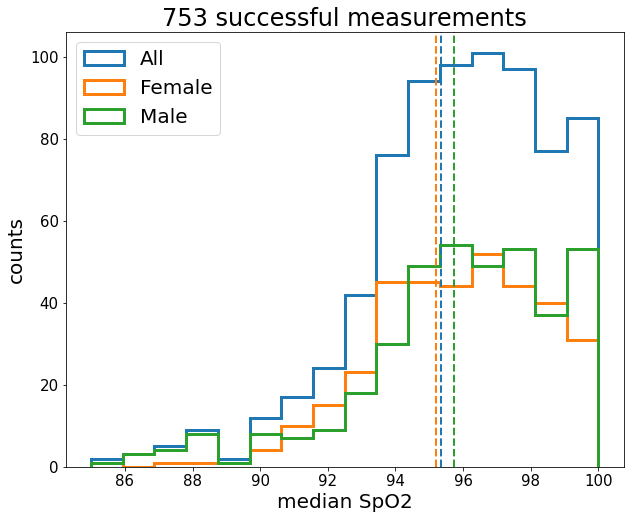

In [226]:
plt.figure(figsize=(10,8))
plt.hist(SpO2,bins=16,range=(85,100)  ,label='All'   ,histtype='step',lw=3,color='C0')
plt.axvline(np.mean(SpO2),color='C0',lw=2,ls='dashed')
plt.hist(f_SpO2,bins=16,range=(85,100),label='Female',histtype='step',lw=3,color='C1')
plt.axvline(np.mean(f_SpO2),color='C1',lw=2,ls='dashed')
plt.hist(m_SpO2,bins=16,range=(85,100),label='Male'  ,histtype='step',lw=3,color='C2')
plt.axvline(np.mean(m_SpO2),color='C2',lw=2,ls='dashed')
plt.title(str(len(SpO2))+' successful measurements')
plt.xlabel('median SpO2')
plt.ylabel('counts')
plt.legend(loc=2)
plt.show()

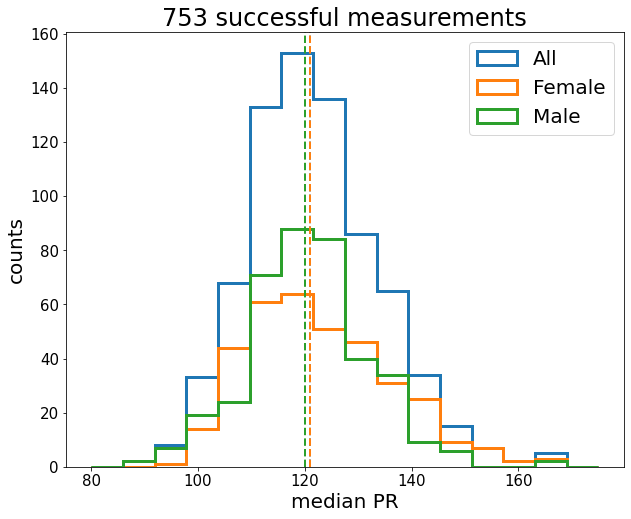

In [227]:
plt.figure(figsize=(10,8))
plt.hist(PR,bins=16  ,range=(80,175),label='All'   ,histtype='step',lw=3,color='C0')
plt.axvline(np.median(PR),color='C0',lw=2,ls='dashed')
plt.hist(f_PR,bins=16,range=(80,175),label='Female',histtype='step',lw=3,color='C1')
plt.axvline(np.median(f_PR),color='C1',lw=2,ls='dashed')
plt.hist(m_PR,bins=16,range=(80,175),label='Male'  ,histtype='step',lw=3,color='C2')
plt.axvline(np.median(m_PR),color='C2',lw=2,ls='dashed')
plt.title(str(len(PR))+' successful measurements')
plt.xlabel('median PR')
plt.ylabel('counts')
plt.legend()
plt.show()

/home/giorgio/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/giorgio/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/giorgio/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/giorgio/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/giorgio/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:8

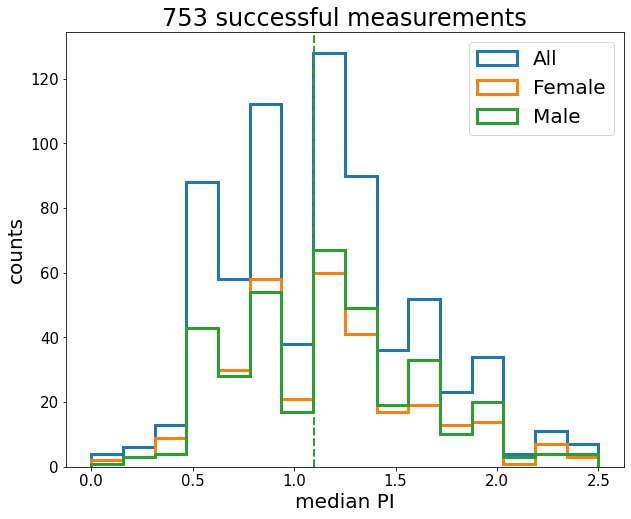

1.1


/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


In [536]:
PI = np.array(PI)
f_PI = np.array(f_PI)
m_PI = np.array(m_PI)

plt.figure(figsize=(10,8))
plt.hist(PI,bins=16  ,range=(0,2.5),label='All'   ,histtype='step',lw=3,color='C0')
plt.axvline(np.median(PI[PI>0.]),color='C0',lw=2,ls='dashed')
plt.hist(f_PI,bins=16,range=(0,2.5),label='Female',histtype='step',lw=3,color='C1')
plt.axvline(np.median(f_PI[f_PI>0.]),color='C1',lw=2,ls='dashed')
plt.hist(m_PI,bins=16,range=(0,2.5),label='Male'  ,histtype='step',lw=3,color='C2')
plt.axvline(np.median(m_PI[m_PI>0.]),color='C2',lw=2,ls='dashed')
plt.title(str(len(PI))+' successful measurements')
plt.xlabel('median PI')
plt.ylabel('counts')
plt.legend()
plt.show()
print(np.median(PI[PI>0]))

# Split babies in Days according to the file name

In [537]:
#FMC001.measurements[0]['SpO2'].notna()[FMC001.measurements[0]['SpO2'].notna()]
print(len(FMC007.measurements[0]['SpO2'].dropna()))
print(len(FMC007.measurements[0]['SpO2']))

325
325


In [538]:
ALL_BABIES = []
for i in range(len(master)):
    try:
        ALL_BABIES.append(baby(master['Study Number (Original)'][i]))
    except:
        pass
# Or, if you have already list_objects, it's the same
#ALL_BABIES = list_objects

In [539]:
print(len(ALL_BABIES))

260


In [540]:
DAY1 = 0
DAY2 = 0
DAY3 = 0
DAY4 = 0
DAY5 = 0
DAY6 = 0
DAY7 = 0
DAY8 = 0

#I shouldn't append the baby but just the measurements
REC_DAY1 = []
REC_DAY2 = []
REC_DAY3 = []
REC_DAY4 = []
REC_DAY5 = []
REC_DAY6 = []
REC_DAY7 = []
REC_DAY8 = []

for i in range(len(ALL_BABIES)):
    for j in range(len(ALL_BABIES[i].files)):
        filename = ALL_BABIES[i].files[j].split('/')[-1]
        if "Day1" in filename:
            DAY1 = DAY1+1
            REC_DAY1.append((ALL_BABIES[i].measurements[j],ALL_BABIES[i].gender,ALL_BABIES[i].baby_id))
        elif "Day2" in filename:
            DAY2 = DAY2+1
            REC_DAY2.append((ALL_BABIES[i].measurements[j],ALL_BABIES[i].gender,ALL_BABIES[i].baby_id))
        elif "Day3" in filename:
            DAY3 = DAY3+1
            REC_DAY3.append((ALL_BABIES[i].measurements[j],ALL_BABIES[i].gender,ALL_BABIES[i].baby_id))
        elif "Day4" in filename:
            DAY4 = DAY4+1
            REC_DAY4.append((ALL_BABIES[i].measurements[j],ALL_BABIES[i].gender,ALL_BABIES[i].baby_id))
        elif "Day5" in filename:
            DAY5 = DAY5+1
            REC_DAY5.append((ALL_BABIES[i].measurements[j],ALL_BABIES[i].gender,ALL_BABIES[i].baby_id))
        elif "Day6" in filename:
            DAY6 = DAY6+1
            REC_DAY6.append((ALL_BABIES[i].measurements[j],ALL_BABIES[i].gender,ALL_BABIES[i].baby_id))
        elif "Day7" in filename:
            DAY7 = DAY7+1
            REC_DAY7.append((ALL_BABIES[i].measurements[j],ALL_BABIES[i].gender,ALL_BABIES[i].baby_id))
        elif "Day8" in filename:
            DAY8 = DAY8+1
            REC_DAY8.append((ALL_BABIES[i].measurements[j],ALL_BABIES[i].gender,ALL_BABIES[i].baby_id))
            
            
print('Number of recordings in Day1: ',DAY1, '  ' , len(REC_DAY1))
print('Number of recordings in Day2: ',DAY2, '  ' , len(REC_DAY2))
print('Number of recordings in Day3: ',DAY3, '  ' , len(REC_DAY3))
print('Number of recordings in Day4: ',DAY4, '  ' , len(REC_DAY4))
print('Number of recordings in Day5: ',DAY5, '  ' , len(REC_DAY5))
print('Number of recordings in Day6: ',DAY6, '  ' , len(REC_DAY6))
print('Number of recordings in Day7: ',DAY7, '  ' , len(REC_DAY7))
print('Number of recordings in Day8: ',DAY8, '  ' , len(REC_DAY8))
TOT = DAY1+DAY2+DAY3+DAY4+DAY5+DAY6+DAY7+DAY8
print('Total number of recordings:   ',TOT)

Number of recordings in Day1:  492    492
Number of recordings in Day2:  65    65
Number of recordings in Day3:  75    75
Number of recordings in Day4:  63    63
Number of recordings in Day5:  50    50
Number of recordings in Day6:  6    6
Number of recordings in Day7:  0    0
Number of recordings in Day8:  2    2
Total number of recordings:    753


In [560]:
d1_spo2=[]
d1_f_spo2=[]
d1_m_spo2=[]

d1_PR=[]
d1_f_PR=[]
d1_m_PR=[]

d1_PI=[]
d1_f_PI=[]
d1_m_PI=[]


for rec in REC_DAY3:
    d1_spo2.append(np.median(rec[0]['SpO2'].dropna()))
    d1_PR.append(np.median(rec[0]['PR'].dropna()))
    try:
        d1_PI.append(np.median(rec[0]['PI'].dropna()))
    except:
        d1_PI.append(np.nan)
    
    if rec[1] == 'Female':
        d1_f_spo2.append(np.median(rec[0]['SpO2'].dropna()))
        d1_f_PR.append(np.median(rec[0]['PR'].dropna()))
        try:
            d1_f_PI.append(np.median(rec[0]['PI'].dropna()))
        except:
            d1_PI.append(np.nan)
        
    elif rec[1] == 'Male':
        d1_m_spo2.append(np.median(rec[0]['SpO2'].dropna()))
        d1_m_PR.append(np.median(rec[0]['PR'].dropna()))
        try:
            d1_m_PI.append(np.median(rec[0]['PI'].dropna()))
        except:
            d1_m_PI.append(np.nan)
    else:
        print("Not specified gender for baby:", rec[2])


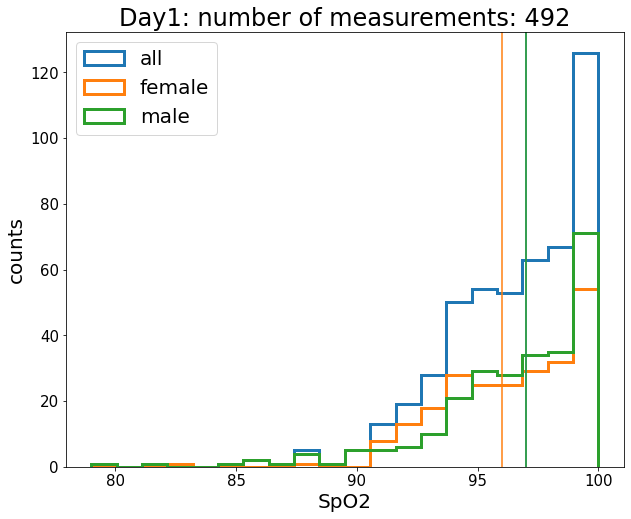

490


In [542]:
plt.figure(figsize=(10,8))
plt.hist(d1_spo2,range=(79,100),  bins=20  ,histtype='step',lw=3,density=False,color='C0',label='all')
plt.hist(d1_f_spo2,range=(79,100),bins=20,histtype='step',lw=3,density=False,color='C1',label='female')
plt.hist(d1_m_spo2,range=(79,100),bins=20,histtype='step',lw=3,density=False,color='C2',label='male')
plt.axvline(np.median(d1_spo2),color='C0')
plt.axvline(np.median(d1_f_spo2),color='C1')
plt.axvline(np.median(d1_m_spo2),color='C2')
plt.xlabel('SpO2')
plt.ylabel('counts')
plt.title('Day1: number of measurements: '+str(len(d1_spo2)))
plt.legend()
plt.show()
print(len(d1_f_spo2)+len(d1_m_spo2))

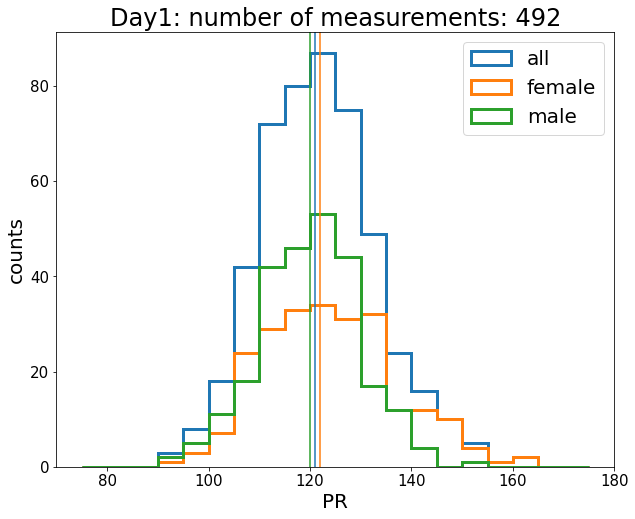

490


In [543]:
plt.figure(figsize=(10,8))
plt.hist(d1_PR,  bins=20  ,range=(75,175),histtype='step',lw=3,density=False,color='C0',label='all')
plt.hist(d1_f_PR,bins=20  ,range=(75,175),histtype='step',lw=3,density=False,color='C1',label='female')
plt.hist(d1_m_PR,bins=20  ,range=(75,175),histtype='step',lw=3,density=False,color='C2',label='male')
plt.axvline(np.median(d1_PR),color='C0')
plt.axvline(np.median(d1_f_PR),color='C1')
plt.axvline(np.median(d1_m_PR),color='C2')
plt.xlabel('PR')
plt.ylabel('counts')
plt.title('Day1: number of measurements: '+str(len(d1_PR)))
plt.legend()
plt.show()
print(len(d1_f_PR)+len(d1_m_PR))

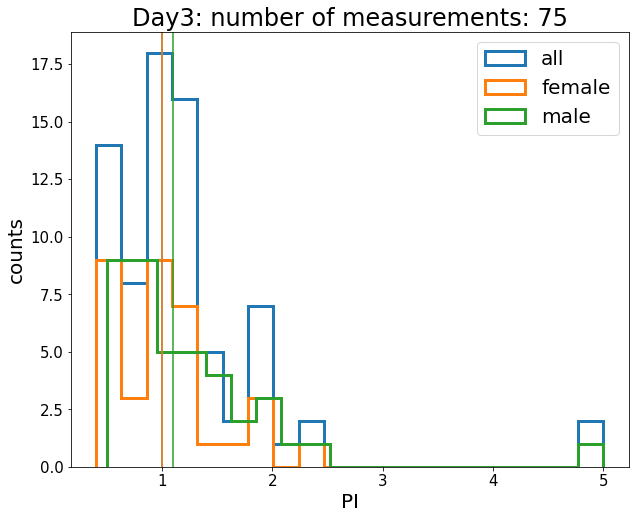

75


In [561]:
d1_PI   = np.array(d1_PI)
d1_f_PI = np.array(d1_f_PI)
d1_m_PI = np.array(d1_m_PI)

d1_PI   = d1_PI  [np.where((d1_PI   >0.)&(d1_PI   <7000.))]
d1_f_PI = d1_f_PI[np.where((d1_f_PI >0.)&(d1_f_PI <7000.))]
d1_m_PI = d1_m_PI[np.where((d1_m_PI >0.)&(d1_m_PI <7000.))]


plt.figure(figsize=(10,8))
plt.hist(d1_PI,  bins=20  ,histtype='step',lw=3,density=False,color='C0',label='all')
plt.hist(d1_f_PI,bins=20  ,histtype='step',lw=3,density=False,color='C1',label='female')
plt.hist(d1_m_PI,bins=20  ,histtype='step',lw=3,density=False,color='C2',label='male')
plt.axvline(np.median(d1_PI),color='C0')
plt.axvline(np.median(d1_f_PI),color='C1')
plt.axvline(np.median(d1_m_PI),color='C2')
plt.xlabel('PI')
plt.ylabel('counts')
plt.title('Day3: number of measurements: '+str(len(d1_PI)))
plt.legend()
plt.show()
print(len(d1_f_PI)+len(d1_m_PI))

In [478]:
type('ciao')

str

In [479]:
for baby in ALL_BABIES:
    for j in range(len(baby.files)):
        if np.median((baby.measurements[j]['PR']).dropna()) >300.:
            #np.median(rec[0]['SpO2'].dropna())
            print(baby.baby_id)

In [480]:
for r in REC_DAY1:
    try: 
        if np.median(r[0]['PI'].dropna())>300:
            print(r[2],np.median(r[0]['PI'].dropna()))
    except:
        print(r[2],r[0]['PI'][0])

/home/giorgio/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/giorgio/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Some correlations

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


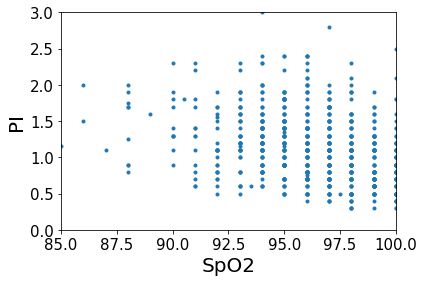

In [297]:
SpO2 = np.array(SpO2)
PI = np.array(PI)
PR = np.array(PR)
sel = np.where((SpO2>60)&(PI<100))
plt.plot(SpO2[sel],PI[sel],".")
plt.xlim(85,100)
plt.ylim(0,3)
plt.xlabel('SpO2')
plt.ylabel('PI')
plt.show()

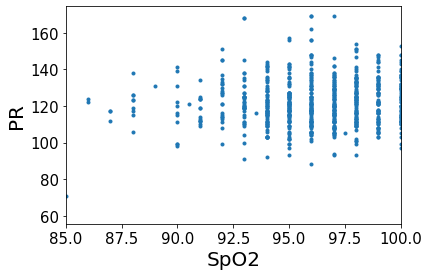

In [298]:
plt.plot(SpO2[sel],PR[sel],".")
plt.xlim(85,100)
#plt.ylim(0,3)
plt.xlabel('SpO2')
plt.ylabel('PR')
plt.show()

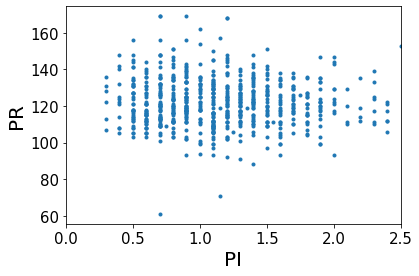

In [299]:
plt.plot(PI[sel],PR[sel],".")
plt.xlim(0,2.5)
#plt.ylim(0,3)
plt.xlabel('PI')
plt.ylabel('PR')
plt.show()

# Testing the day format (and change it to the most likely)

In [272]:
FMC005.measurements[3]['Date'][0]

'14-07-03'

In [273]:
FMC005.baby_id

'FMC005'

In [313]:
baby5 = baby('FMC005')

baby5.measurements[0]['Date'][0]

'03-05-14'

In [325]:
str(baby5.measurements[0]['Date'][0][-2:]).split('-')[0]

'14'

In [353]:
y = []
i = 0
counts_US = 0
counts_UK = 0

for o in list_objects_fairly_good:
    y1 = int(str(o.measurements[0]['Date'][0])[-2:])
    y2 = int(str(o.measurements[0]['Date'][0])[0:2])
    if y1 != 14:
        counts_US = counts_US+1
        y.append(y2)
    else:
        counts_UK = counts_UK +1
        y.append(y1)
    
    #y.append(y2)
    
    

In [354]:
print(counts_UK)
print(counts_US)

183
63


(array([  0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0., 244.]),
 array([ 0.        ,  0.93333333,  1.86666667,  2.8       ,  3.73333333,
         4.66666667,  5.6       ,  6.53333333,  7.46666667,  8.4       ,
         9.33333333, 10.26666667, 11.2       , 12.13333333, 13.06666667,
        14.        ]),
 <a list of 15 Patch objects>)

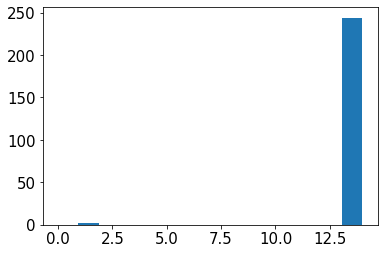

In [350]:
plt.hist(y,range=(0,14),bins=15)

In [290]:
np.median([])

/home/giorgio/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/giorgio/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [27]:
b = baby('fmc058',verbose=True)

The original name of the baby case is:  FMC058
Reading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_058/G_FMC058_Day1_Rt Foot.csv
Reading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_058/G_PHN_FMC058_Day4_Lt Foot.csv
Reading file:  /home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_058/G_PHN_FMC058_Day4_Rt wrist.csv
['Date' 'Time' 'SpO2' 'PR' 'PI' ' Exceptions' 'Exception Labels'
 'Unnamed: 7']
['Date' 'Time' 'SpO2' 'PR' 'PI' ' Exceptions' 'Exception Labels'
 'Unnamed: 7' 'Unnamed: 8' 'Unnamed: 9' 'Unnamed: 10' 'Unnamed: 11'
 'Unnamed: 12' 'Unnamed: 13' 'Unnamed: 14']
['Date' 'Time' 'SpO2' 'PR' 'PI' ' Exceptions' 'Exception Labels'
 'Unnamed: 7' 'Unnamed: 8' 'Unnamed: 9' 'Unnamed: 10' 'Unnamed: 11'
 'Unnamed: 12' 'Unnamed: 13' 'Unnamed: 14']


In [689]:
get_folder_for_baby('rgh041',whole_path=True)

'/home/giorgio/Desktop/NHS/TOST_data/TOST RGH Data Groomed/G_RGH 041/'

In [653]:
'rgh041'.upper()

'RGH041'

In [724]:
FMC001.measurements[0].columns.values

array(['Date', 'Time', 'SpO2', 'PR', 'PI'], dtype=object)

In [734]:
d = pd.read_csv('/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_057/G_PHN_FMC057_Day5_Rt wrist.csv')
d.columns.values

np.median(d['SpO2'].dropna())

93.0